In [ ]:
'''

'''

In [2]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [langgraph]


In [ ]:
# langgraph -> Orchestration(to create pipeline by combining a multiple components) -> pipeline

In [8]:
# 1. Langgraph -> nodes, edges, state
# node -> represent function. 
# edges -> represent connectivity between nodes (functions).
# state
from langgraph.graph import Graph
from langgraph.graph import StateGraph
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image
from langchain.embeddings import HuggingFaceEmbeddings

# embeddings = GoogleGenerativeAIEmbeddings(
#     model = "models/embedding-001"
# )

# llm = ChatGoogleGenerativeAI(
#     model = "gemini-1.5-pro"
# )

def LLM(input):
    llm = HuggingFaceEmbeddings(
        model = "sentence-transformers/all-MiniLM-L6-v2"
    )

    response = llm.invoke(input).content

    return response

def Counter_Token(input):
    token = input.split()
    token_number = len(token)
    response = f"Total number of token in the generated output:  {token_number}"
    return response

# creating a graph by initializing the Graph. 
workflow = Graph()

workflow.add_node("My LLM", LLM)
workflow.add_node("Token Counter", Counter_Token)
workflow.add_edge("My LLM", "Token Counter")

workflow.set_entry_point("My LLM")
workflow.set_finish_point("Token Counter")

app = workflow.compile()

# Visualizing with the help of IPython display method. 
display(Image(app.get_graph))

FileNotFoundError: No such file or directory: '<bound method Pregel.get_graph of <langgraph.graph.graph.CompiledGraph object at 0x124973390>>'

FileNotFoundError: No such file or directory: '<bound method Pregel.get_graph of <langgraph.graph.graph.CompiledGraph object at 0x124973390>>'

<IPython.core.display.Image object>

In [5]:
# 
app.invoke("what is a agentic ai explain me in very detailed manner ?")

/var/folders/60/nyxyyg_s35nggs_b1klsdhm40000gn/T/ipykernel_44083/4272434875.py:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  llm = HuggingFaceEmbeddings(


ValidationError: 1 validation error for HuggingFaceEmbeddings
model
  Extra inputs are not permitted [type=extra_forbidden, input_value='sentence-transformers/all-MiniLM-L6-v2', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden

In [ ]:
input = "what is a agentic ai explain me in very detailed manner ?"
# Checking the output of the each node. 
for output in app.stream(input):
    for key, value in output.items():
        print(f"Here is output from {key}")
        print("_______")
        print(value)

#### **state graphs**

In [6]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
loader = DirectoryLoader(
    "../data",
    glob = "./*.txt",
    loader_cls = TextLoader
)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500, 
    chunk_overlap = 50
)

new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

doc_strings

# storing the data in vector db. 
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs = {"k": 3})

# 

query  = "why scientist was working hard for what kind of vaccines ?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadaata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

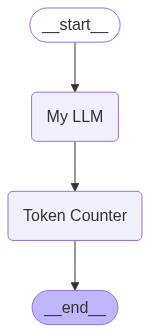

In [ ]:
# We are flowing this state across the different nodes inside the langraph workflow. 
AgentState = {}

AgentState["messages"] = []

def function1(AgentState):
    message = AgentState["messages"]

    question = message[-1]

    complete_prompt = "You task is to provide only the brief answer based on the user query. \ Don't include too much reasoning. Following is the user query: " + question

    response = llm.invoke(complete_prompt)

    AgentState["messages"].append(response.content) # appending LLM call response to the AgentState. 

    return AgentState

# This below is the RAG pipeline. 
def function2(AgentState): 

    messages = AgentState["messages"]

    question = messages[0] ## Fetching the user question.

    template = """Answer the question based only on the following context: 
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt 
        | llm 
        | StrOutputParser()
    )
    
    result = retrieval_chain.invoke(question)
    return result

# This is the Orchestration -> Creating a Pipeline. 
workflow = Graph()
workflow.add_node("LLM", function1)
workflow.add_node('RAGtool', function2)
workflow.add_edge("LLM", "RAGtool")
workflow.set_entry_point("LLM")
workflow.set_finish_point("RAGtool")
app2 = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
app2.invoke({"messages": ["hi", "how are you doing ?", "Okay I am good"]})

Okay I am good
None


In [ ]:
input = "what is a meaning of cancer from prolonged exposure to burn pits raveged health lung?"
# Checking the output of the each node. 
for output in app.stream({"messages": ["what is a meaning of cancer from prolonged exposure to burn pits raveged health lung?"]}):
    for key, value in output.items():
        print(f"Here is output from {key}")
        print("_______")
        print(value)

In [16]:
AgentState["messages"].append("Hi")

AgentState["messages"].append("Hello")

AgentState["messages"].append("we need to study mL. ")

AgentState["messages"].append("Okay FIne...")

In [27]:
AgentState

{'messages': []}